In [310]:
from utilsGeneral import UtilsGeneral
from utilsModel import UtilsModel
from utilsPlot import UtilsPlot
from KnapSack import KnapSack
from shallowNet.shallowNet import shallowNet, DenseTranspose
import numpy as np
import copy
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
import collections



In [2]:
knapSack = KnapSack("100_5_25_1")
utg = UtilsGeneral(knapSack)
utm = UtilsModel(utg)
utp = UtilsPlot(utilsGeneral = utg, utilsModel = utm)
fitness_function = knapSack.Fitness

Best Objective Value: 0


In [3]:
set1, set2 = utg.load_datasets(1,2)
model1, model2= utg.load_models(1,2)

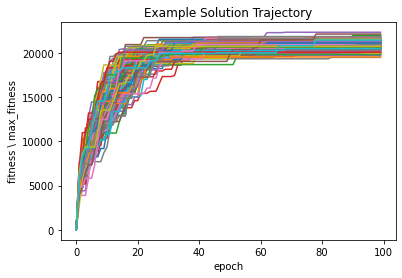

In [40]:
max_fitness, final_solutions = utp.plot_trajectory_evolution(100, learning_steps = 100, sample_number=100, model = model2)

In [45]:
max_fitness

22309.0

In [8]:
def TrainToSol(sol):
    ConvertSol = np.copy(sol)
    ConvertSol[sol == -1] = 0
    return ConvertSol


In [38]:
def SolDistribution(sol):
    arr = np.zeros(100)
    for i in sol:
        arr += TrainToSol(i)
    return arr/ np.shape(sol)[0]


In [33]:
def AverageElements(sol):
    avg = 0 
    for i in sol: 
        avg += sum(TrainToSol(i))
    return avg/ np.prod(np.shape(sol))


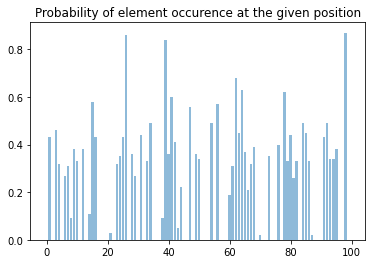

In [48]:
plt.figure()
plt.title("Probability of element occurence at the given position")
plt.bar(np.arange(100), SolDistribution(final_solutions), align = "center", alpha = 0.5)
plt.show()

In [678]:
def partition(array, numbers_of_partition=4, lambda_cof=2):

    def get_index_list(array, element):
        return [i for i, e in enumerate(array) if e == element]

    def remove_from_list(array, indexes):
        copyarr = copy.copy(array)
        for i in indexes: 
            array.remove(copyarr[i])
        return array

    distribution = SolDistribution(array)
    std = np.std(distribution)
    #mean = 0.5 - np.mean(distribution)
    mean = 0.4 # STILL TO IMPROVE
    #mean = np.median(SolDistribution(final_solutions))
    array = distribution.tolist()
    arraycopy = copy.copy(array)
    res = []
    mapindex = {}
    stop = False
    for i in range(1,numbers_of_partition+1): 
        tmp_left = []
        tmp_right = []
        array_len = len(arraycopy)
        for j in range(array_len):
            element = arraycopy.pop(0)
            if mapindex.get(element) == None:
                    mapindex[element] = get_index_list(array, element)
            if i == numbers_of_partition:
                if element < mean:
                    tmp_left.append(mapindex[element].pop())
                else:
                    tmp_right.append(mapindex[element].pop())
            else:
                if element >= mean - i * std/lambda_cof and element <= mean:
                    tmp_left.append(mapindex[element].pop())
                    
                elif element >= mean and element <= mean + i * std/lambda_cof:
                    tmp_right.append(mapindex[element].pop())
                else:
                    arraycopy.append(element)
                
        res.insert(0, np.asarray(tmp_left))
        res.append(np.asarray(tmp_right))

    return res, mean, std




In [680]:
pars = partition(final_solutions)
sum = 0
np.shape(pars[0][0])[0]
for i in range(8):
    sum +=np.shape(pars[0][i])[0]
sum



100

KeyboardInterrupt: 

In [648]:
array = [1,2,3,1,2,3,5,6,3,2,1,10]
array.append(0)
array

[1, 2, 3, 1, 2, 3, 5, 6, 3, 2, 1, 10, 0]

In [577]:

get_index_list(array, 1)
remove_from_list(array, get_index_list(array, 1))
def part(array):
    def get_index_list(array, element):
        return [i for i, e in enumerate(array) if e == element]

    def remove_from_list(array, indexes):
        copyarr = copy.copy(array)
        for i in indexes: 
            array.remove(copyarr[i])
        return array
    copyarr = copy.copy(array)
    list.sort(array)
    res = []
    for i in array[:]:
        index_list = get_index_list(array, i)
        element_to_remove = copyarr[index_list[0]]
        print(index_list, " - ", element_to_remove, " - ", i, " - ", array )
        for j in index_list:
            res.append(j)
            array.remove(element_to_remove)
    return res

In [547]:
ll = SolDistribution(final_solutions).tolist()
tmp = [i for i, e in enumerate(ll) if e == 0.38]
print(tmp)
ll.remove(0.38)
ll.remove(0.38)
ll.remove(0.38)

[i for i, e in enumerate(ll) if e == 0.38]

[9, 12, 95]


[]

[1, 16, 25, 91]  -  0.43
[3]  -  0.46
list index -  [7, 61]  -  0.31
list index -  [9, 12, 95]  -  0.38
list index -  [4, 23, 67]  -  0.32
list index -  [28, 40, 49]  -  0.36
[31, 80]  -  0.44
list index -  [10, 33, 79, 82, 86]  -  0.33
[42]  -  0.41
list index -  [50, 93, 94]  -  0.34
[34, 54, 84, 92]  -  0.49
[63, 85]  -  0.45
list index -  [65]  -  0.37
list index -  [68]  -  0.39
list index -  [24, 73]  -  0.35
list index -  [76]  -  0.4
list index -  [6, 29]  -  0.27
[15]  -  0.58
[41]  -  0.6
list index -  [44]  -  0.22
[47]  -  0.56
[56]  -  0.57
list index -  [60]  -  0.19
[64]  -  0.63
[78]  -  0.62
list index -  [8, 38]  -  0.09
list index -  [14]  -  0.11
list index -  [43]  -  0.05
[62]  -  0.68
list index -  [81]  -  0.26
final shape (23,)


([array([ 0,  2,  5, 11, 13, 17, 18, 19, 20, 22, 27, 30, 32, 35, 36, 37, 45,
         46, 48, 51, 52, 53, 55, 57, 58, 59, 69, 71, 72, 74, 75, 77, 83, 88,
         89, 90, 96, 97, 99,  0,  2,  5, 11, 13, 17, 18, 19, 20, 22, 27, 30,
         32, 35, 36, 37, 45, 46, 48, 51, 52, 53, 55, 57, 58, 59, 69, 71, 72,
         74, 75, 77, 83, 88, 89, 90, 96, 97, 99,  0,  2,  5, 11, 13, 17, 18,
         19, 20, 22, 27, 30, 32, 35, 36, 37, 45, 46, 48, 51, 52, 53, 55, 57,
         58, 59, 69, 71, 72, 74, 75, 77, 83, 88, 89, 90, 96, 97, 99,  0,  2,
          5, 11, 13, 17, 18, 19, 20, 22, 27, 30, 32, 35, 36, 37, 45, 46, 48,
         51, 52, 53, 55, 57, 58, 59, 69, 71, 72, 74, 75, 77, 83, 88, 89, 90,
         96, 97, 99,  0,  2,  5, 11, 13, 17, 18, 19, 20, 22, 27, 30, 32, 35,
         36, 37, 45, 46, 48, 51, 52, 53, 55, 57, 58, 59, 69, 71, 72, 74, 75,
         77, 83, 88, 89, 90, 96, 97, 99,  0,  2,  5, 11, 13, 17, 18, 19, 20,
         22, 27, 30, 32, 35, 36, 37, 45, 46, 48, 51, 52, 53, 55, 57, 58, 59,

In [427]:
def choose_group():
    p = [0.009, 0.02, 0.14, 0.34,0.34,0.14, 0.002, 0.009]
    r = np.random.choice(8, 1, p=p)
    x = np.random.choice(3,1, p = [0.1, 0.3, 0.6])
    return r, r+x-1

In [468]:
p = [0.009, 0.02, 0.14, 0.34,0.34,0.14, 0.002, 0.009]
#p.index(0.14)
tmp  = [i for i, e in enumerate(p) if e == 0.14]
for i in [1,2]:
    del p[i]
p

[0.009, 0.14, 0.34, 0.14, 0.002, 0.009]

In [464]:
thisdict = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}
thisdict.get("modell")== None

True

In [376]:
array

[0.4, 0.16537476691540615, -0.06925046616918773, -0.30387569925378155]

0.9820000000000001

In [3]:
train_size = 200
#trainY1 = utg.generate_training_set(knapSack.Size,train_size)
#utg.save(trainY1)
trainY1, trainY2 = utg.load_datasets(1,2)


[INFO]: Loss plot was saved in the directory:  saved_plots\to_delete.png


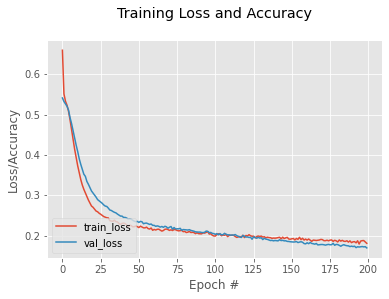

In [24]:
compression = 0.8
epochs = 200
batch_size = 10
reg_cof = 0.0002
dropout = 0.2
lr = 0.002

model1 = shallowNet.build(
    input_shape=knapSack.Size, 
    reg_cof= reg_cof, 
    lr = lr, 
    dropout= dropout, 
    compression=compression
)

H1 = model1.fit(
    trainY1, trainY1, 
    validation_split = 0.05,
    epochs=epochs, 
    batch_size=batch_size, 
    shuffle=True,
    verbose=0)
utp.plot_model_loss(H1, "to_delete.png", epochs)



[INFO]: Trajectory evoultion plot was saved in the directory:  saved_plots\to_delete.png
[INFO]: Trajectory evoultion plot was saved in the directory:  saved_plots\to_delete.png


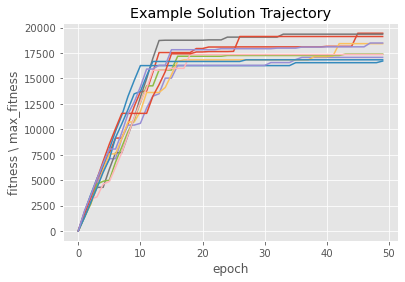

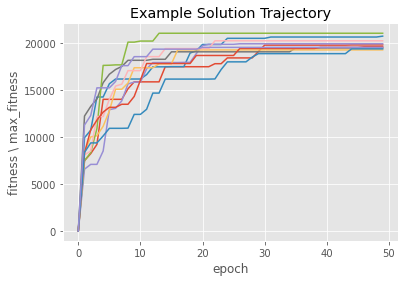

In [5]:
utp.plot_trajectory_evolution(knapSack.Size, 10, 50 ,"to_delete.png")
utp.plot_trajectory_evolution(knapSack.Size, 10, 50, "to_delete.png", model1 )

[INFO]: Loss plot was saved in the directory:  saved_plots\to_delete.png


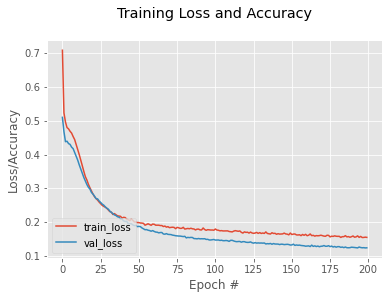

In [15]:

model2 = shallowNet.build(
    input_shape=knapSack.Size, 
    reg_cof= reg_cof, 
    lr = lr, 
    dropout= dropout, 
    compression=compression
)

H2 = model2.fit(
    trainY2, trainY2, 
    validation_split = 0.05,
    epochs=epochs, 
    batch_size=batch_size, 
    shuffle=True,
    verbose=0)
utp.plot_model_loss(H2, "to_delete.png", epochs)

In [16]:
model3 = utm.add_layer_to_model(model2, compression, dropout, reg_cof,lr,True )

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  8080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                5184      
_________________________________________________________________
dense_transpose_4 (DenseTran (None, 80)                5264      
_________________________________________________________________
dense_transpose_3 (DenseTran (None, 100)               818

[INFO]: Loss plot was saved in the directory:  saved_plots\to_delete.png


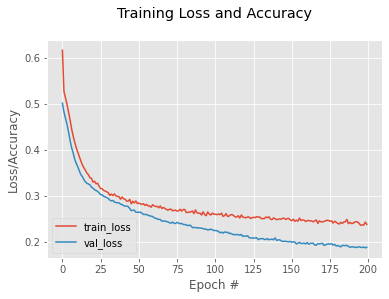

In [17]:
H3 = model3.fit(
    trainY2, trainY2, 
    validation_split = 0.05,
    epochs=epochs, 
    batch_size=batch_size, 
    shuffle=True,
    verbose=0)
utp.plot_model_loss(H3, "to_delete.png", epochs)

[INFO]: number of convoluted layers is equal to:  2
[INFO]: Weights of model were saved in the directory:  saved_plots\to_delete.png


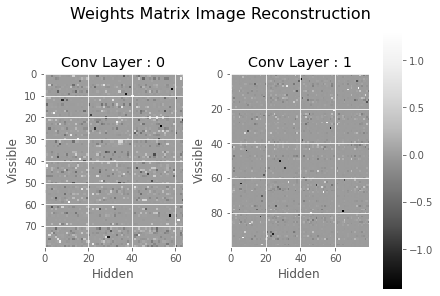

In [18]:
utp.plot_weights_model(model3, "to_delete.png")


[INFO]: Evolution model plot was saved in the directory:  saved_plots\to_delte.png


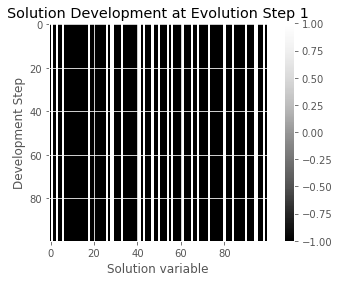

In [31]:
utp.plot_evolution_model(model3, trainY1, "to_delte.png", learning_steps=100)

[INFO]: Fitness development phase plot was saved in the directory:  saved_plots\to_delete.png
[INFO]: Fitness development phase plot was saved in the directory:  saved_plots\to_delete.png


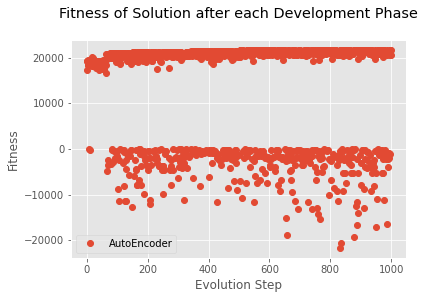

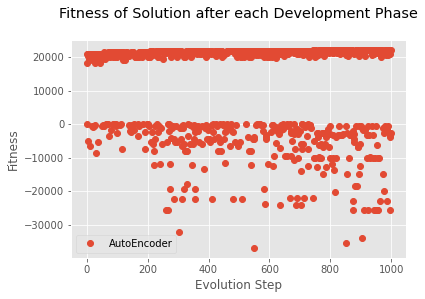

In [20]:
utp.plot_fitness_development_phase(model1, trainY1, "to_delete.png")
utp.plot_fitness_development_phase(model3, trainY1, "to_delete.png")

[INFO]: Trajectory evoultion plot was saved in the directory:  saved_plots\to_delete.png


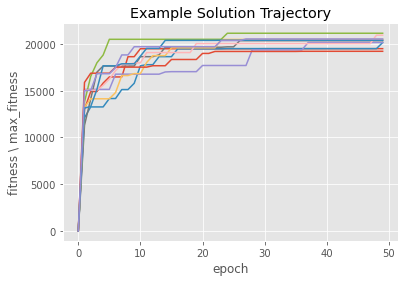

In [23]:
utp.plot_trajectory_evolution(knapSack.Size, 10, 50, "to_delete.png", model3 )

In [32]:
modeltmp = utg.load_models(3)[0]

In [35]:
#utp.plot_weights_model(modeltmp, "to_delete.png")
np.shape(modeltmp.layers[-1].get_weights()[1])

(100, 80)

In [36]:
modeltmp.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                5184      
_________________________________________________________________
dense_transpose_2 (DenseTran (None, 80)                5264      
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 100)               8180